# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from **scratch instead of using any pre-existing libraries** to do so:

(1) Count the frequency of all the N-grams (N=3) and (N=2).

(2) Calculate the probabilities for all the bigrams in the dataset by using the formula  count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative
probabilities of each review in terms of other reviews (abstracts, or tweets) by using the formula  frequency (noun phrase) / max frequency (noun phrase) on the whole dataset.

Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [ ]:

import re
from collections import Counter
import pandas as pd

# Loading the dataset
file_path = "cleaned_narrators_data.csv"
df = pd.read_csv(file_path)

# Function to extract potential noun phrases
def extract_noun_phrases(text):
    words = text.split()
    noun_phrases = []
    for i in range(len(words) - 1):
        if re.match(r'\b[a-z]+\b', words[i]) and re.match(r'\b[a-z]+\b', words[i+1]):
            noun_phrases.append(words[i] + ' ' + words[i+1])
    return noun_phrases

noun_phrase_counts = Counter()
for bio in df["Cleaned_Bio"].dropna():
    noun_phrase_counts.update(extract_noun_phrases(bio))

# Maximum frequency
max_freq = max(noun_phrase_counts.values())

# Compute relative probabilities for noun phrases
relative_probabilities = {
    phrase: count / max_freq for phrase, count in noun_phrase_counts.items()
}

sorted(relative_probabilities.items(), key=lambda x: x[1], reverse=True)[:10]



[('concentr camp', 1.0),
 ('war ii', 0.8164116828929068),
 ('world war', 0.8122392211404729),
 ('male born', 0.6105702364394993),
 ('assembl center', 0.5257301808066759),
 ('femal born', 0.4951321279554937),
 ('nisei male', 0.4909596662030598),
 ('nisei femal', 0.37830319888734354),
 ('lo angel', 0.36995827538247567),
 ('ii remov', 0.36022253129346316)]

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any **pre-existing libraries** to do so.

In [3]:
import numpy as np
import pandas as pd
from collections import Counter


file_path = "cleaned_narrators_data.csv"
df = pd.read_csv(file_path)

# Tokenize and count
def compute_tf(doc):
    words = doc.split()
    tf_counts = Counter(words)
    total_terms = len(words)
    return {term: count / total_terms for term, count in tf_counts.items()} if total_terms > 0 else {}

# IDF
def compute_idf(docs):
    num_docs = len(docs)
    doc_freq = Counter()
    for doc in docs:
        unique_terms = set(doc.split())
        doc_freq.update(unique_terms)

    return {term: np.log(num_docs / (1 + freq)) for term, freq in doc_freq.items()}  # Smoothing added

# Cosine Similarity
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    return dot_product / (norm_vec1 * norm_vec2) if norm_vec1 * norm_vec2 != 0 else 0

# TF-IDF Matrix
documents = df["Cleaned_Bio"].dropna().tolist()
tf_matrix = [compute_tf(doc) for doc in documents]
idf_values = compute_idf(documents)

tfidf_matrix = [{term: tf * idf_values.get(term, 0) for term, tf in doc.items()} for doc in tf_matrix]

all_terms = sorted(idf_values.keys())
tfidf_array = np.array([[doc.get(term, 0) for term in all_terms] for doc in tfidf_matrix])

print("TF-IDF Matrix Shape:", tfidf_array.shape)

# Query Processing
query = "An Outstanding movie with a haunting performance and best character development"
query_tf = compute_tf(query)
query_tfidf = np.array([query_tf.get(term, 0) * idf_values.get(term, 0) for term in all_terms])

# Compute Cosine Similarities
similarities = [cosine_similarity(query_tfidf, doc_vector) for doc_vector in tfidf_array]

# Rank Documents
ranked_docs = sorted(enumerate(similarities), key=lambda x: x[1], reverse=True)

print("\nTop 5 Relevant Documents Based on Query:")
for rank, (doc_index, score) in enumerate(ranked_docs[:5], 1):
    print(f"Rank {rank}: Document {doc_index} - Similarity: {score:.4f}")
    print(f"Document Content: {documents[doc_index][:200]}...\n")  # Show a snippet of the document


TF-IDF Matrix Shape: (900, 3640)

Top 5 Relevant Documents Based on Query:
Rank 1: Document 0 - Similarity: 0.0000
Document Content: nisei femal born may selleck washington spent much childhood beaverton oregon father own farm influenc earli age parent convers christian world war ii remov portland assembl center oregon minidoka con...

Rank 2: Document 1 - Similarity: 0.0000
Document Content: nisei male born june seattl washington grew area seattl japanes american attend univers washington japan bomb pearl harbor remov puyallup assembl center washington minidoka concentr camp idaho left mi...

Rank 3: Document 2 - Similarity: 0.0000
Document Content: nisei femal born octob seattl washington famili own oper success groceri store prior world war ii bomb pearl harbor remov puyallup assembl center washington minidoka concentr camp idaho left camp atte...

Rank 4: Document 3 - Similarity: 0.0000
Document Content: nisei femal born juli boyl height california earli age went live famili friend

## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit or Fine tune bert model).

(2) Visualize the word embedding model you created. (PCA and T-sne)

(3) Calculate the cosine similarity between a few pairs of words to see if the model captures semantic similarity accurately.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.data.path.append("/usr/local/nltk_data")
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')

file_path = "cleaned_narrators_data.csv"
df = pd.read_csv(file_path)


df["Cleaned_Bio"] = df["Cleaned_Bio"].fillna('').astype(str)  # Convert NaN to empty strings

# Tokenize text
sentences = [doc.lower().split() for doc in df["Cleaned_Bio"].fillna("")]


word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=2, workers=4)

# Save model
word2vec_model.save("word2vec_model.bin")

print("Word2Vec model training complete and saved as 'word2vec_model.bin'.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Word2Vec model training complete and saved as 'word2vec_model.bin'.


In [ ]:
from gensim.models import Word2Vec

# Load trained model
word2vec_model = Word2Vec.load("word2vec_model.bin")

print(f"Vocabulary Size: {len(word2vec_model.wv)}")


Vocabulary Size: 2024


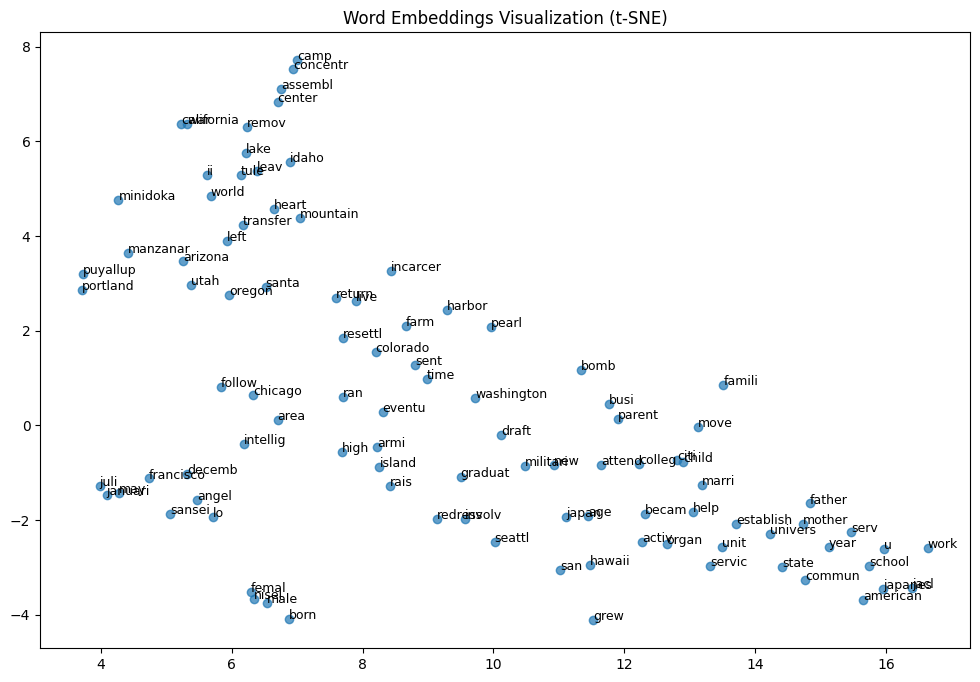

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


words = list(word2vec_model.wv.index_to_key)[:100]  # Taking first 100 words for visualization
word_vectors = np.array([word2vec_model.wv[word] for word in words])

# Reduce dimensions using PCA (from 300D to 50D)
pca = PCA(n_components=50)
word_vectors_pca = pca.fit_transform(word_vectors)


tsne = TSNE(n_components=2, perplexity=30, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors_pca)

plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.7)

# Annotate words
for i, word in enumerate(words):
    plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=9)

plt.title("Word Embeddings Visualization (t-SNE)")
plt.show()


In [ ]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(word1, word2, model):
    """Calculate cosine similarity between two words."""
    if word1 in model.wv and word2 in model.wv:
        vec1 = model.wv[word1]
        vec2 = model.wv[word2]
        similarity = dot(vec1, vec2) / (norm(vec1) * norm(vec2))
        return similarity
    else:
        return "One or both words not in vocabulary"

# Example word pairs
word_pairs = [("good", "great"), ("king", "queen"), ("happy", "sad"), ("car", "bike")]

# print cosine similarity
for w1, w2 in word_pairs:
    print(f"Cosine Similarity ({w1}, {w2}): {cosine_similarity(w1, w2, word2vec_model)}")


Cosine Similarity (good, great): 0.997943103313446
Cosine Similarity (king, queen): 0.9838496446609497
Cosine Similarity (happy, sad): One or both words not in vocabulary
Cosine Similarity (car, bike): One or both words not in vocabulary


## Question 4 (20 Points)

**Create your own training and evaluation data for sentiment analysis.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.




1.   Which NLP Task you would like perform on your selected dataset
(NER, Summarization, Sentiment Analysis, Text classficication)
2.  Explain your labeling Schema you have used and mention those labels

3.  You can take AI assistance for labeling the data only.



In [ ]:
# 1. Sentiment Analysis
# 2. columns : document_id, clean_text, sentiment(positive, negative, or neutral)

In [ ]:
# The GitHub link of your final csv file


# Link: https://github.com/Gopi-1818/Gopikrishna_INFO5731_Spring2025/blob/main/sentiment_annotated_dataset.csv



# Mandatory Question

Provide your thoughts on the assignment by filling this survey link. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

The assignment was a thoughtful and difficult task that allowed me to apply my analytical skills to the maximum. One of the difficulties I faced was ensuring data integrity and fixing inconsistencies in the dataset, which meant extensive preprocessing. Another difficulty was tuning the models to get improved results, which was time-consuming but worth it.
